<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/newautoencoderTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

transform=transforms.ToTensor()
train_data = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
num_workers=0 #?
batch_size = 50

train_loader = DataLoader(train_data,batch_size=batch_size,num_workers=num_workers)
test_loader = DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



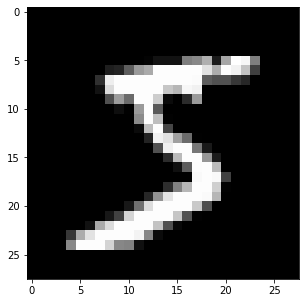

In [ ]:
#데이터 시각화
dataiter = iter(train_loader)
images, labels = dataiter.next()
#이미지 데이터 하나를 추출한다.
imges=images.numpy()
#plt가 ndarray를 사용하므로 텐서를 numpy로 변환 시켜준다.

img = np.squeeze(images[0])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.imshow(img, cmap='gray')

In [ ]:
#CNN_Denoise를 정의하기
#Conv2D(input_channel,Output_channel,filter_size,stride는 이동 간격(기본1), padding=1(image주변을 padding으로 둘러싸서 이미지 크기 키움. 사용안하는 0이 default임)
#Max_pooling으로 이미지의 대표 feature(최대,최소,평균)를 추출
class ConvDenoiser(nn.Module):
  def __init__(self):

    #Encoder layer
    super(ConvDenoiser, self).__init__()
    self.conv1 = nn.Conv2d(1,32,3, padding=1) #depth를 1에서 32로 변환, 필터 크기는 3X3. zero 패딩 사용하므로 이미지 크기는 8X8로 유지 된다.
    self.conv2 = nn.Conv2d(32,16,3, padding=1)  #depth를 32에서 16으로 줄이고 필터 크기는 3X3
    self.conv3 = nn.Conv2d(16,8,3, padding =1) #depth를 16에서 8로, 필터 크기는 3X3
    self.pool = nn.MaxPool2d(2,2) #필터 크기 2X2로 해서 이미지의 feature 추출함.

    #Decoder layer
    self.t_conv1 = nn.ConvTranspose2d(8,8,3,stride=2) #stride로 필터의 간격을 2로 늘려서 차원을 늘린다. 패딩 사용 하지 않으므로 7X7로 사이즈 줄어듦
    self.t_conv2 = nn.ConvTranspose2d(8,16,2,stride=2) #transpose layer가 뭐하는거지? conv2D와 동일한 개수를 써야 되나?
    self.t_conv3= nn.ConvTranspose2d(16,32,2,stride=2) #필터의 간격을 2로 늘리는 이유?
    self.conv_out = nn.Conv2d(32,1,3,padding=1) #depth32->1로 만든다. 패딩 사용해서 마지막은 8X8 사이즈로 만들어준다.


  def forward(self,x):
    
    ##encode##
    ##활성화 함수 relu를 사용해서 hidden_layer를 쌓는다. 
    

    x = F.relu(self.conv1(x)) #1단 히든레이어
    x = self.pool(x)

    x = F.relu(self.conv2(x)) #2단 히든레이어
    x = self.pool(x)
    
    x = F.relu(self.conv3(x)) #3단 히든레이어
    x = self.pool(x)
    #Compressed representaion이다.

    ##Decode##
    ##마찬가지로 hidden_layer를 만든다.
    x = F.relu(self.t_conv1(x)) #1단 히든레이어 
    x = F.relu(self.t_conv2(x)) 
    x = F.relu(self.t_conv3(x))
    x = F.sigmoid(self.conv_out(x)) #마지막에 sigmoid 쓰는 이유->마지막 출력 레이어는 0~1.0사이의 값을 사용함. 

    return x


In [ ]:
#모델 실행하기
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
#model의 loss_function 만들기
#optimizer는 error(또는 loss)를 줄이는데 사용함. weight+=weight-n*dE/dw로 gradient 미세조정한다. n은 학습율,E는 에러율이다.E(w)
import torch
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Gradient와 learning rate를 둘 다 고려해서 방향을 찾는 Adam optimizer를 사용한다.
n_epochs = 20

noise_factor = 0.5

for epoch in range(1, n_epochs+1):
  #loss mornitor
  train_loss = 0.0

#model training
  for data in train_loader:
       images, _ = data
       noisy_imgs=images+noise_factor*torch.randn(*images.shape) #*images.shape를 왜 곱하지?
       noisy_imgs = np.clip(noisy_imgs, 0., 1.) # 클립(limit)로 인해 0미만은 0.0으로, 1초과면 1.0로 반환함. 노이즈 추가로 범위를 벗어난 값을 범위안에 들어오게조정한다.
       optimizer.zero_grad() #모든 최적화 된 변수(optimizer?)의 gradient를 clear한다. 

    #foward pass임. 노이즈 입력에 의한 모델 예측값을 출력한다.

       outputs = model(noisy_imgs)
    #caculate the loss
    #target은 원본이미지이다.
       loss = criterion(outputs, images) #MSELoss(input, target)로 오차를 구해낸다.
       loss.backward()  #자동 미분 진행한다.
       optimizer.step() #파라미터 업데이트함(최적화 한 걸음 실행하겠다) 
       train_loss += loss.item()*images.size(0) #images.size(0)가 뭔데?

   #평균적인 학습 통계를 출력하기
       train_loss = train_loss/len(train_loader)
       print('Epoch:{} \t Training Loss: {:.6f}'.format(epoch,train_loss)) #중괄호 사이로 format(문자열포멧팅함수)에서 지정한 값이 들어간다


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch:16 	 Training Loss: 0.001169
Epoch:16 	 Training Loss: 0.001084
Epoch:16 	 Training Loss: 0.000995
Epoch:16 	 Training Loss: 0.001080
Epoch:16 	 Training Loss: 0.001031
Epoch:16 	 Training Loss: 0.001100
Epoch:16 	 Training Loss: 0.001235
Epoch:16 	 Training Loss: 0.001082
Epoch:16 	 Training Loss: 0.001099
Epoch:16 	 Training Loss: 0.001023
Epoch:16 	 Training Loss: 0.001154
Epoch:16 	 Training Loss: 0.001121
Epoch:16 	 Training Loss: 0.001140
Epoch:16 	 Training Loss: 0.001118
Epoch:16 	 Training Loss: 0.001157
Epoch:16 	 Training Loss: 0.000969
Epoch:16 	 Training Loss: 0.001069
Epoch:16 	 Training Loss: 0.000938
Epoch:16 	 Training Loss: 0.001020
Epoch:16 	 Training Loss: 0.001117
Epoch:16 	 Training Loss: 0.000953
Epoch:16 	 Training Loss: 0.001022
Epoch:16 	 Training Loss: 0.001060
Epoch:16 	 Training Loss: 0.001155
Epoch:16 	 Training Loss: 0.001066
Epoch:16 	 Training Loss: 0.001065
Epoch:16 	 Training Loss: 0.001092
Epoch:16 	 Training